In [1]:
%load_ext autoreload
%autoreload 2

from dataset import GarbageDataModule, GarbageDataset
from pathlib import Path
import wandb
import torch

In [2]:
labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    "train_labels_indom": ["alum", "plastic", "glass"],
}
batch_size = 32

dm = GarbageDataModule(
    labels_set,
    data_dir=Path("dataset"),
    batch_size=batch_size,
    num_workers=10,
)

dm.setup()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.26475513 0.8428905


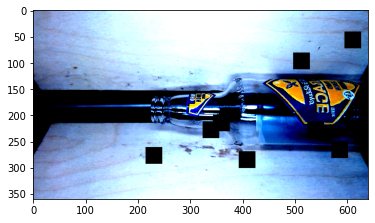

In [4]:
import matplotlib.pyplot as plt

def show_tensor_img(tensor):
    plt.imshow(tensor.permute(1, 2, 0))

x, y, idx = dm.train_dataset[500]

show_tensor_img(x['top_img'])
print(x['weight'], x['metal'])

# Cac loss

In [3]:
import torch
from pytorch_lightning import Trainer
from cac_loss_models import CACLossNet

cac_net = CACLossNet({'num_classes' : 3}, {'magnitude' : 3, 'alpha' : 2.25}, 'Adam', {'lr' : 1e-3, 'weight_decay' : 1e-4})
cac_net = cac_net.load_from_checkpoint('ood_models/Greedbox_ood/n3sok1th/checkpoints/epoch=162-step=4401.ckpt')
trainer = Trainer(
    accelerator='cpu', 
    # devices=[0], 
)

prediction = trainer.predict(cac_net, dm.val_dataloader())

preds = torch.cat([p[0] for p in prediction], dim=0)
labels = torch.cat([p[1] for p in prediction], dim=0)
logits = torch.cat([p[2] for p in prediction], dim=0)

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/michael/miniconda3/envs/greenbo

Predicting: 0it [00:00, ?it/s]

In [4]:
# Indom acc
((labels == preds) & (labels != 3)).float().sum() / (labels != 3).sum()

tensor(0.9486)

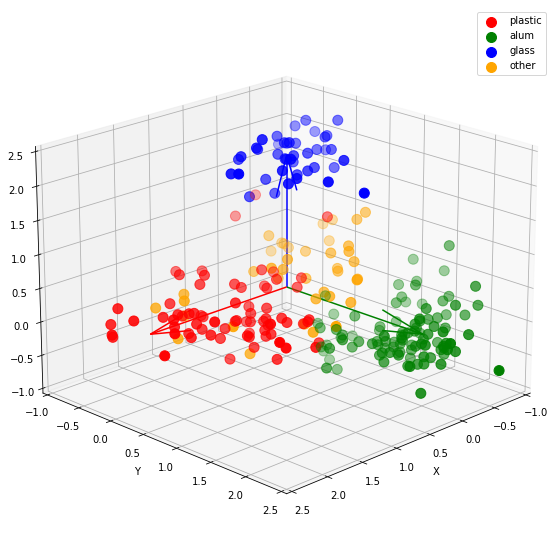

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_3d(X, labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')   
    # fig, ax = plt.subplots()
    label_name = {0: "plastic", 1: "alum", 2 : "glass", 3: "other"}

    cdict = {0: "red", 1: "green", 2 : "blue", 3: "orange"}

    X = X.detach().numpy()
    for label in np.unique(labels):
        ix = np.where(labels == label)
        ax.scatter(xs = X[ix, 0], ys = X[ix, 1], zs=X[ix, 2], c = cdict[label], label = label_name[label], s = 100)
    # plt.scatter(x=X[:, 0], y=X[:, 1], c=labels)
    ax.legend()
    ax.set_xlim3d([-1, 2.5])
    ax.set_ylim3d([-1, 2.5])
    ax.set_zlim3d([-1, 2.5])
    ax.view_init(20, 45)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    quiver1 = ax.quiver([0],[0],[0],[2],[0],[0], colors='r')
    quiver2 = ax.quiver([0],[0],[0],[0],[2],[0], colors='g')
    quiver3 = ax.quiver([0],[0],[0],[0],[0],[2], colors='b')


plot_3d(logits, labels)

In [6]:
from cac_loss_models import CacLossClassifierNet

classifier_net = CacLossClassifierNet(cac_net.model, 'Adam', {'lr' : 1e-3, 'weight_decay' : 1e-4})
classifier_net = classifier_net.load_from_checkpoint('ood_models/Greedbox_ood/xzkwwya6/checkpoints/epoch=4-step=155.ckpt')

trainer = Trainer(
    accelerator='cpu', 
    # devices=[0],
)

prediction = trainer.predict(classifier_net, dm.test_dataloader())

preds = torch.cat([p[0] for p in prediction], dim=0)
probs = torch.cat([p[1] for p in prediction], dim=0)
labels = torch.cat([p[2] for p in prediction], dim=0)
ids = torch.cat([p[3] for p in prediction], dim=0)


/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'base_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['base_model'])`.
  rank_zero_warn(
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/michael/m

Predicting: 0it [00:00, ?it/s]

In [7]:
# Total acc
(preds == labels).float().mean()

tensor(0.8747)

In [8]:
# OOD acc
((preds == labels) & (labels == 3)).sum() / (labels == 3).sum()

tensor(0.9383)

In [9]:
# Indom acc
((preds == labels) & (labels != 3)).sum() / (labels != 3).sum()

tensor(0.8589)

In [10]:
labels[preds != labels]

tensor([2, 2, 3, 0, 2, 2, 3, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 1, 0, 0, 2, 3, 2, 0, 3, 0, 0, 2, 0,
        0, 0, 0])

/tmp/ipykernel_6743/3799143379.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
/tmp/ipykernel_6743/3799143379.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


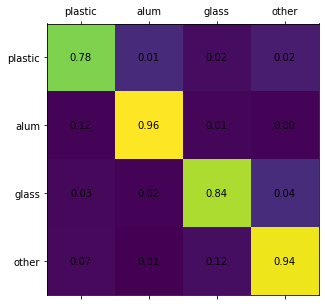

In [22]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np

confmat = ConfusionMatrix(task='multiclass', num_classes=4, normalize='true')
conf_matrix = confmat(preds, labels)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

In [11]:
len(ids[preds != labels])

51

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

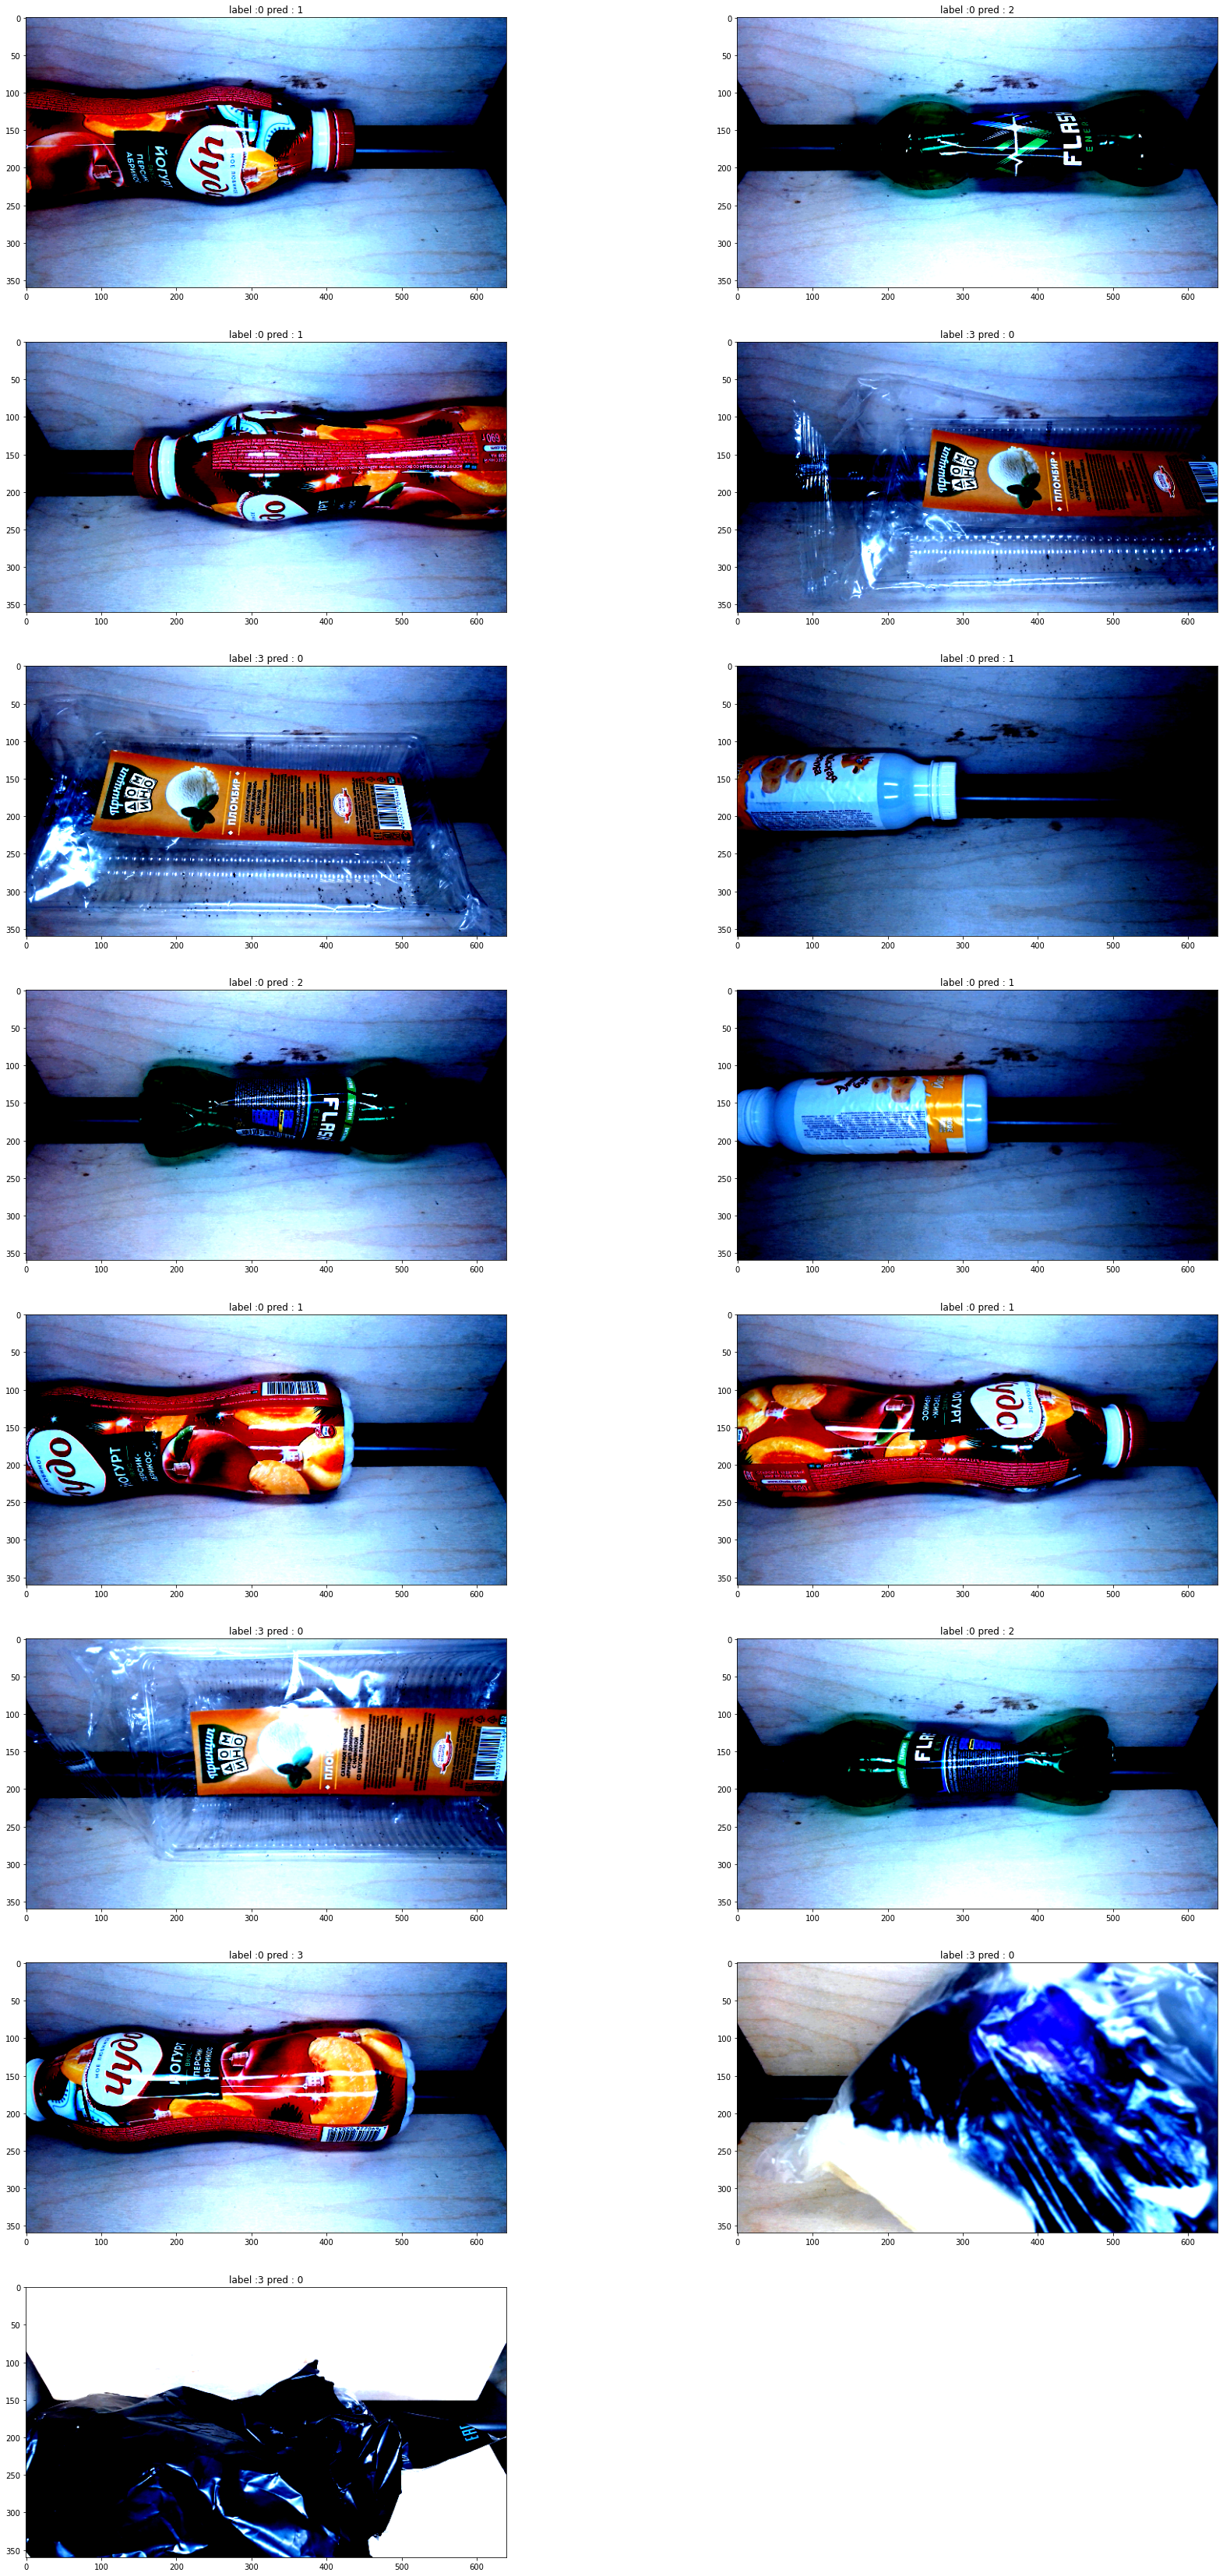

In [30]:
plt.figure(figsize = (30, 60))

wrong_indxs = preds != labels
for i, (id, pred, label) in enumerate(zip(ids[wrong_indxs], preds[wrong_indxs], labels[wrong_indxs])):
    plt.subplot(len(ids[preds != labels]) // 2 + 1, 2, i+1)
    img = dm.val_dataset[id][0]['top_img']
    plt.imshow(img.permute(1, 2, 0))
    plt.title('label :' + str(int(label)) + ' pred : ' + str(int(pred)))

# Default 4 class

In [24]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from train_3_class_model import DefaultMobileNet

default_net = DefaultMobileNet({'num_classes' : 4}, 'Adam', {'lr' : 1e-3, 'weight_decay' : 1e-4})

wandb_logger = WandbLogger(log_model=True, project='Greedbox_ood')
labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    "train_labels_indom": ["alum", "plastic", "glass"],
}
batch_size = 32

dm = GarbageDataModule(
    labels_set,
    data_dir=Path("dataset"),
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()


trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=100)
        ],
    default_root_dir='ood_models',
    logger=wandb_logger,
)


trainer.fit(default_net, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes | Out sizes
------------------------------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0      | ?        | ?        
1 | softmax     | Softmax          | 0      | ?        | ?        
2 | model       | MobileNetV3      | 1.5 M  | ?        | ?        
------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.098     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:

prediction = trainer.predict(default_net, dm.test_dataloader())

preds = torch.cat([p[0] for p in prediction], dim=0)
labels = torch.cat([p[1] for p in prediction], dim=0)
logits = torch.cat([p[2] for p in prediction], dim=0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting: 9it [00:00, ?it/s]

In [26]:
(preds == labels).float().mean()

tensor(0.9115)

In [29]:
((preds == labels) & (labels == 3)).sum() / (labels == 3).sum()

tensor(0.9630)

In [30]:
((preds == labels) & (labels != 3)).sum() / (labels != 3).sum()

tensor(0.8988)

/tmp/ipykernel_6743/4211632297.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
/tmp/ipykernel_6743/4211632297.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


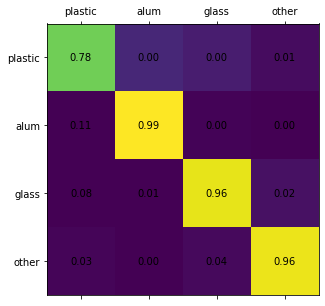

In [28]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np

confmat = ConfusionMatrix(task='multiclass', num_classes=4, normalize='true')
conf_matrix = confmat(preds, labels)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

# SupContrastive learning

In [4]:
from ood_models import SupContrastMobileNet, CACLossNet, DefaultMobileNet
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

sup_net = SupContrastMobileNet({'features_num' : 128}, 'SGD', {'lr' : 1e-4, 'weight_decay' : 1e-5})

wandb_logger = WandbLogger(log_model=True, project='Greedbox_ood')
labels_set = {
    "train_labels": ["alum", "plastic", "glass"],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    "train_labels_indom": ["alum", "plastic", "glass"],
}
batch_size = 24

dm = GarbageDataModule(
    labels_set,
    data_dir=Path("dataset"),
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()


trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_loss",
                mode="min",
            ),
            EarlyStopping(monitor="val_loss", mode="min", patience=100)
        ],
    default_root_dir='ood_models',
    logger=wandb_logger,
    log_every_n_steps=30,
)


trainer.fit(sup_net, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params | In sizes | Out sizes
-------------------------------------------------------------------
0 | loss_module | SupConLoss  | 0      | ?        | ?        
1 | softmax     | Softmax     | 0      | ?        | ?        
2 | model       | MobileNetV3 | 1.7 M  | ?        | ?        
-------------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.607     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Epoch 58:   0%|          | 0/46 [00:00<?, ?it/s, loss=2.73, v_num=v23d]         

Exception ignored in: <function _releaseLock at 0x7fc1f85799d0>
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch 59:  87%|████████▋ | 40/46 [00:10<00:01,  3.89it/s, loss=2.88, v_num=v23d]

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [84]:
import torch
from ood_models import SupContrastMobileNet
from pytorch_lightning import Trainer

sup_net = SupContrastMobileNet({'features_num' : 256}, 'SGD', {'lr' : 1e-4, 'weight_decay' : 1e-5})
sup_net = sup_net.load_from_checkpoint('ood_models/Greedbox_ood/b81oolmk/checkpoints/epoch=13-step=574.ckpt')
trainer = Trainer(accelerator='gpu', devices=[0],)


prediction = trainer.predict(sup_net, dm.test_dataloader())
logits = torch.cat([p[0] for p in prediction], dim=0)
labels = torch.cat([p[1] for p in prediction], dim=0)

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for SupContrastMobileNet:
	size mismatch for mlp_features.0.weight: copying a param with shape torch.Size([256, 1154]) from checkpoint, the shape in current model is torch.Size([256, 1152]).

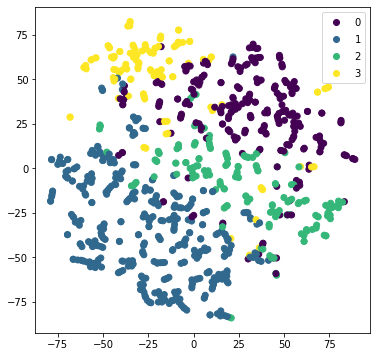

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(X, labels):
    X = X.detach().numpy()
    X_points = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(x=X_points[:, 0], y=X_points[:, 1], c=labels, )
    plt.legend(*scatter.legend_elements())


plot_tsne(logits, labels)

# Classifier

In [3]:
from ood_models import SupContrastMobileNet, CACLossNet, DefaultMobileNet, ClassifierNet
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

classifier = ClassifierNet({'features_num' : 0}, 'Adam', {'lr' : 1e-3, 'weight_decay' : 1e-4})

wandb_logger = WandbLogger(log_model=True, project='Greedbox_ood')
labels_set = {
    "train_labels": ["alum", "plastic", "glass"],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    "train_labels_indom": ["alum", "plastic", "glass"],
}
batch_size = 24

dm = GarbageDataModule(
    labels_set,
    data_dir=Path("dataset"),
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()


trainer = Trainer(
    accelerator='gpu', 
    devices=[0],
    max_epochs=20000,
    callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                monitor="val_acc",
                mode="max",
            ),
            EarlyStopping(monitor="val_acc", mode="max", patience=25)
        ],
    default_root_dir='ood_models',
    logger=wandb_logger,
    log_every_n_steps=30,
)


trainer.fit(classifier, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | softmax          | Softmax          | 0     
1 | base_model       | MobileNetV3      | 2.0 M 
2 | loss_module      | CrossEntropyLoss | 0     
3 | classifier_model | Sequential       | 164 K 
------------------------------------------------------
164 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.840     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Epoch 27: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s, loss=1.02, v_num=w9rr] 


In [20]:
import torch
from ood_models import SupContrastMobileNet, SupContrastClassifier
from pytorch_lightning import Trainer

sup_net = SupContrastClassifier({'features_num' : 512}, 'SGD', {'lr' : 1e-4, 'weight_decay' : 1e-5})
sup_net.load_from_checkpoint('ood_models/Greedbox_ood/d6jcmdxq/checkpoints/epoch=43-step=1540.ckpt')
trainer = Trainer(accelerator='gpu', devices=[0],)


prediction = trainer.predict(sup_net, dm.val_dataloader())
preds = torch.cat([p[0] for p in prediction], dim=0)
probs = torch.cat([p[1] for p in prediction], dim=0)
features =  torch.cat([p[2] for p in prediction], dim=0)
labels = torch.cat([p[3] for p in prediction], dim=0)

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for SupContrastClassifier:
	Missing key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.2.weight", "classifier.2.bias". 
	size mismatch for mlp_features.0.weight: copying a param with shape torch.Size([576, 1152]) from checkpoint, the shape in current model is torch.Size([576, 1154]).

In [18]:
(labels == preds).float().mean()

tensor(0.1660)

In [19]:
preds

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [12]:
preds.shape

torch.Size([253])

# BNN infer

In [33]:
from bayesian_net import MobileNetSensors
from pyro.infer.autoguide import AutoDiagonalNormal
import torch
device = "cuda:0"

model = MobileNetSensors(use_top_mask=False)
model.load_state_dict(torch.load('bnn_saved_models/bnn_best_1.model'))
model = model.to(device)
# guide = AutoDiagonalNormal(model).to(device)
guide = torch.load('bnn_saved_models/bnn_best_1.guide')


In [34]:
from pyro.infer import Predictive
from tqdm import tqdm
import numpy as np

predictive = Predictive(model, guide=guide, num_samples=500, return_sites=("obs", "_RETURN"))
y_preds = []
y_stds = []
ys = []
for x, y, idx in tqdm(dm.test_dataloader()):
    sensors = torch.stack((x["metal"], x["weight"]), dim=1).to(device)
    top_img = x["top_img"].to(device)
    side_img = x["side_img"].to(device)
    top_delta_mask = x['top_delta_mask'].to(device)
    y = y.to(device)
    preds = predictive(top_img, side_img, top_delta_mask, sensors)
    y_pred = preds['obs'].T.detach().cpu().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().cpu().numpy().std(axis=1)

    y_preds.append(y_pred)
    y_stds.append(y_std)
    ys.append(y.detach().cpu().numpy())
    # if len(ys) > 1:
    #     break

ys = np.concatenate(ys, axis=0)
y_preds = np.concatenate(y_preds, axis=0)
y_stds = np.concatenate(y_stds, axis=0)

100%|██████████| 13/13 [02:40<00:00, 12.36s/it]


In [35]:
y_preds.shape, y_stds.shape, ys.shape

((407,), (407,), (407,))

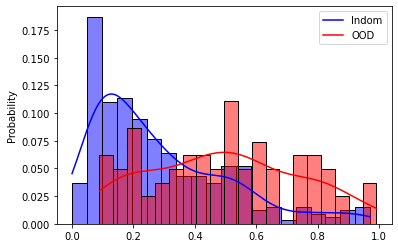

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(y_stds[ys !=3], bins = 20, kde=True, color='blue', stat = 'probability')
sns.histplot(y_stds[ys ==3], bins = 20, kde=True, color='red', stat = 'probability')
plt.legend(labels=['Indom', 'OOD'])

In [37]:
rounded_preds = np.rint(y_preds)
# Indom acc only
((rounded_preds == ys) & (ys != 3)).sum() / (ys != 3).sum()

0.8220858895705522

In [38]:
# OOD Acc 
threshold = 0.5
rounded_preds[y_stds > threshold] = 3
((rounded_preds == ys) & (ys == 3)).sum() / (ys == 3).sum()

0.5061728395061729

In [39]:
# Total acc, 
(rounded_preds == ys).mean()

0.7051597051597052

In [40]:
# Indom acc
((rounded_preds == ys) & (ys != 3)).sum() / (ys != 3).sum()

0.754601226993865

/tmp/ipykernel_6743/1223522242.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
/tmp/ipykernel_6743/1223522242.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


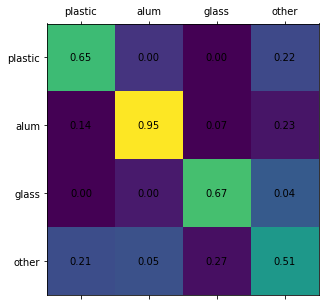

In [42]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np
import torch

confmat = ConfusionMatrix(task='multiclass', num_classes=4, normalize='true')
conf_matrix = confmat(torch.tensor(rounded_preds), torch.tensor(ys))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

# OE infer

In [86]:
from train_outlier_exp import OEMobileNet
from train_3_class_model import DefaultMobileNet

import torch
from pytorch_lightning import Trainer


base_model = DefaultMobileNet(
        {"num_classes": 3}, "Adam", {"lr": 1e-3, "weight_decay": 1e-4}
    )
base_model = base_model.model
model = OEMobileNet(
        {"num_classes": 3},
        "Adam",
        {"lr": 1e-3, "weight_decay": 1e-4},
        base_model=base_model,
    )
model = model.load_from_checkpoint('ood_models/Greedbox_ood/8ciqmnz4/checkpoints/epoch=44-step=1845.ckpt', base_model = base_model)
trainer = Trainer(accelerator='gpu', devices=[0],)

prediction = trainer.predict(model, dm.test_dataloader())
preds = torch.cat([p[0] for p in prediction], dim=0)
labels = torch.cat([p[1] for p in prediction], dim=0)
probs =  torch.cat([p[2] for p in prediction], dim=0)
ids =  torch.cat([p[3] for p in prediction], dim=0)


/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [87]:
((preds == labels) & (labels != 3)).sum() / (labels !=3).sum()

tensor(0.9847)

In [88]:
max_probs = probs.max(dim=1).values
max_probs.shape

torch.Size([407])

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start


    asset.start()
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


Text(0, 0.5, 'Max_prob')

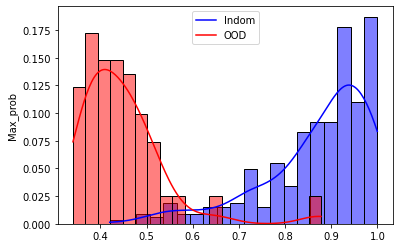

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(max_probs[labels != 3], bins = 20, kde=True, color='blue', stat = 'probability', )
sns.histplot(max_probs[labels == 3], bins = 20, kde=True, color='red', stat = 'probability')
plt.legend(labels=['Indom', 'OOD'])
plt.ylabel("Max_prob")

In [90]:
# Total acc
new_preds = preds
new_preds[max_probs < 0.6] = 3
(new_preds == labels).float().mean()

tensor(0.9484)

In [91]:
# Indom acc
((new_preds == labels) & (labels != 3)).sum() / (labels != 3).sum()

tensor(0.9479)

In [92]:
# OOD acc
((new_preds == labels) & (labels == 3)).sum() / (labels == 3).sum()

tensor(0.9506)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

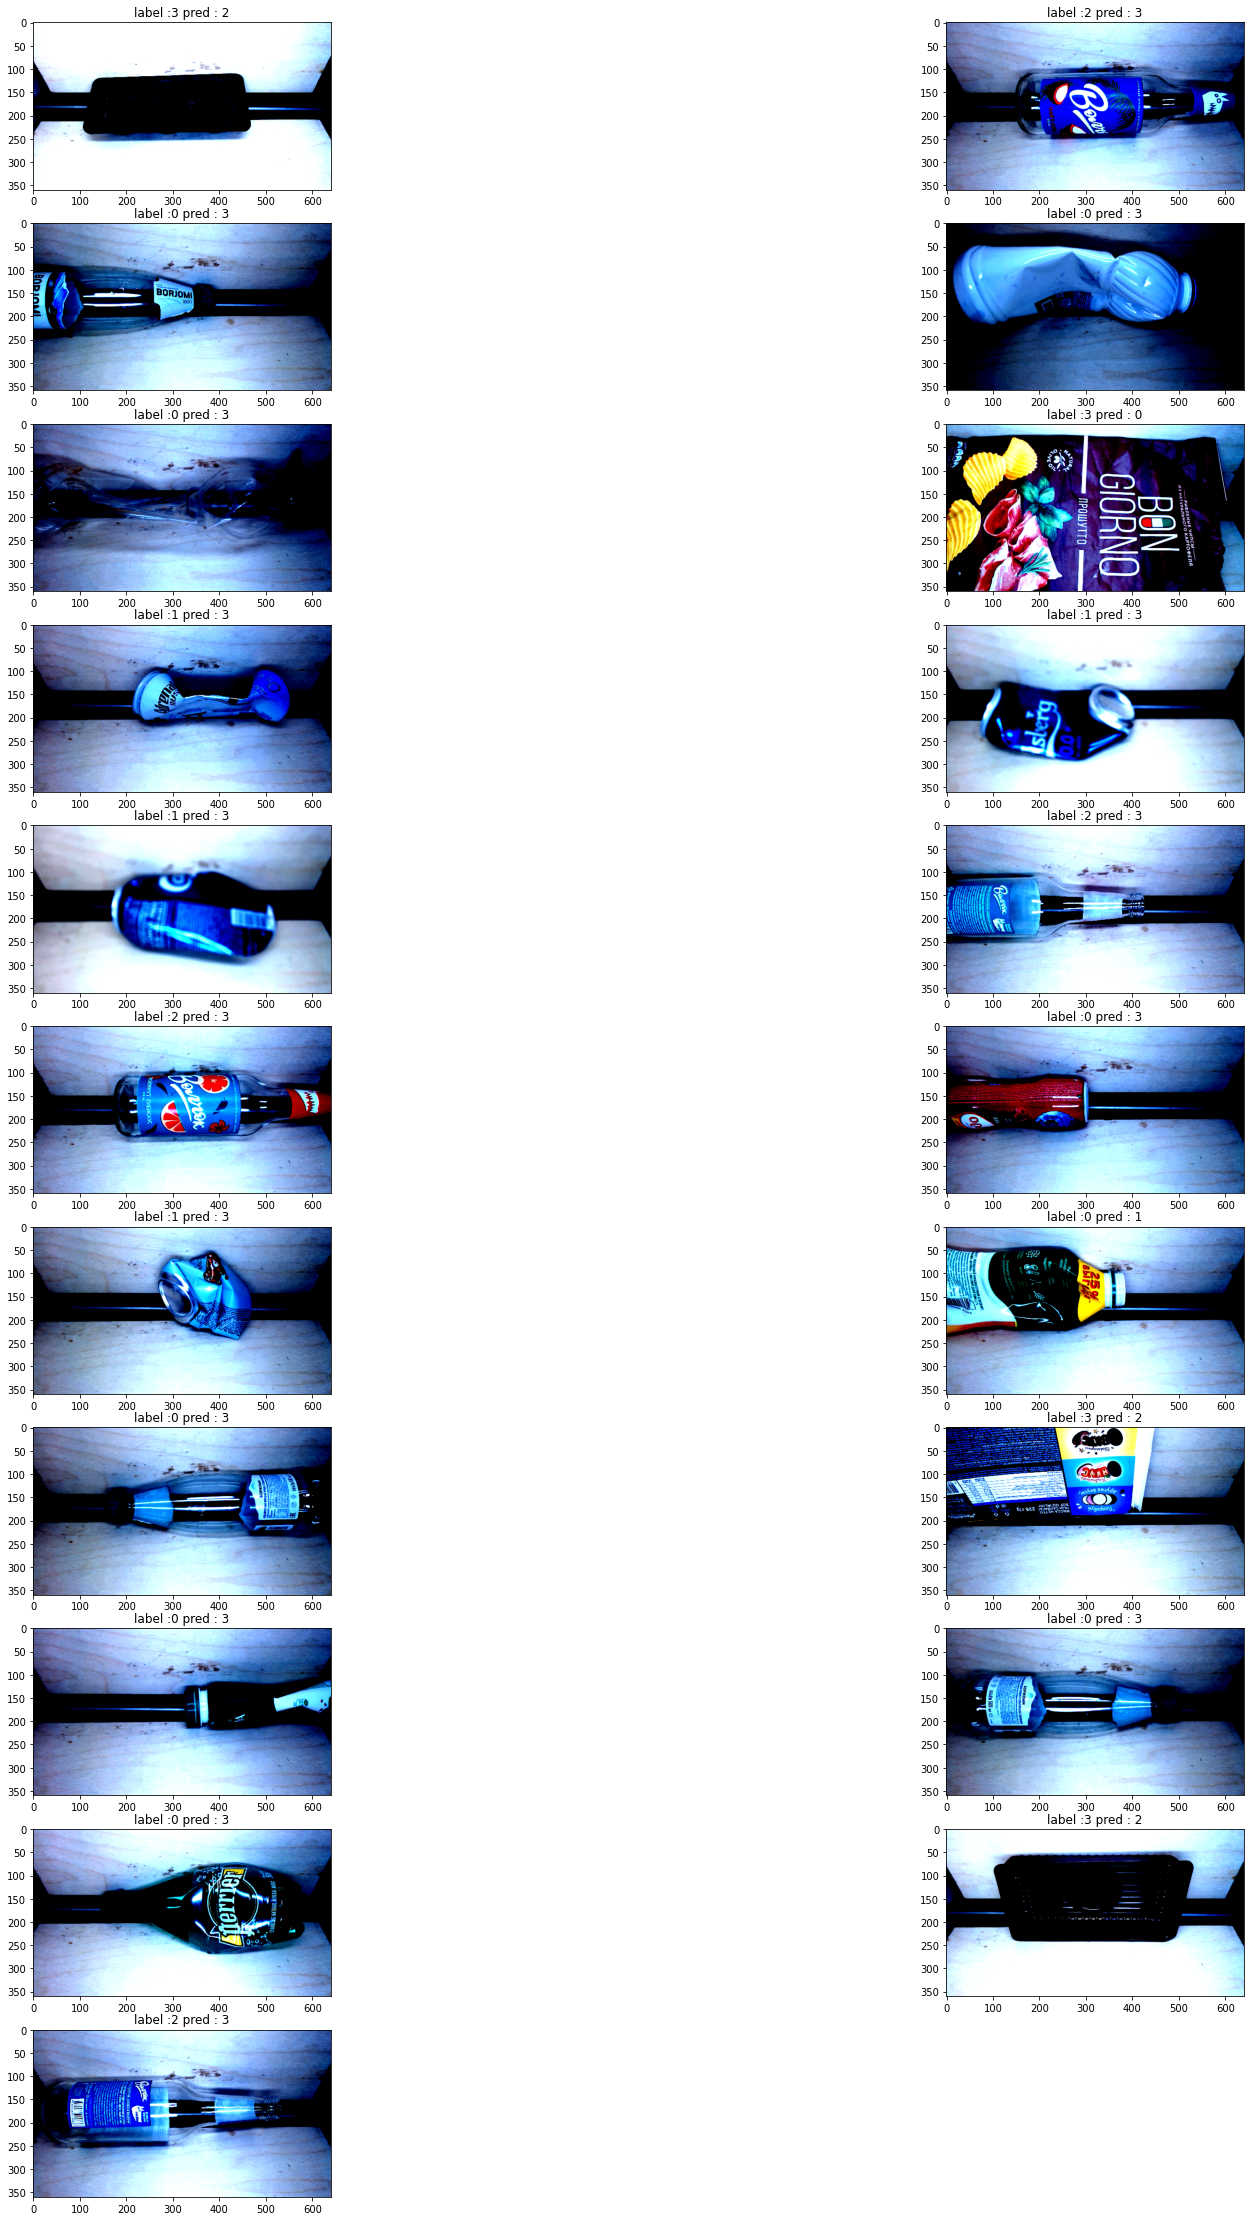

In [93]:
plt.figure(figsize = (30, 40))

wrong_indxs = new_preds != labels
for i, (id, pred, label) in enumerate(zip(ids[wrong_indxs], new_preds[wrong_indxs], labels[wrong_indxs])):
    plt.subplot(len(ids[preds != labels]) // 2 + 1, 2, i+1)
    img = dm.test_dataset[id][0]['top_img']
    plt.imshow(img.permute(1, 2, 0))
    plt.title('label :' + str(int(label)) + ' pred : ' + str(int(pred)))

/tmp/ipykernel_6743/3075112138.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
/tmp/ipykernel_6743/3075112138.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


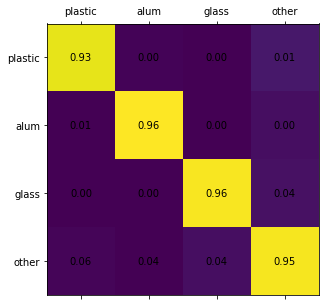

In [63]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np

confmat = ConfusionMatrix(task='multiclass', num_classes=4, normalize='true')
conf_matrix = confmat(new_preds, labels)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

# Energy Loss infer

In [75]:
from energy_model import EnergyMobileNet
from train_3_class_model import DefaultMobileNet

import torch
from pytorch_lightning import Trainer


base_model = DefaultMobileNet(
        {"num_classes": 3}, "Adam", {"lr": 1e-3, "weight_decay": 1e-4}
    )
base_model = base_model.model
model = EnergyMobileNet(
        {"num_classes": 3},
        "Adam",
        {"lr": 1e-3, "weight_decay": 1e-4},
        base_model=base_model,
    )
model = model.load_from_checkpoint('ood_models/Greedbox_ood/gouzml9m/checkpoints/epoch=21-step=902.ckpt', base_model = base_model)
trainer = Trainer(accelerator='gpu', devices=[0],)

prediction = trainer.predict(model, dm.test_dataloader())
preds = torch.cat([p[0] for p in prediction], dim=0)
labels = torch.cat([p[1] for p in prediction], dim=0)
probs =  torch.cat([p[2] for p in prediction], dim=0)
ids =  torch.cat([p[3] for p in prediction], dim=0)


/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [76]:
((preds == labels) & (labels != 3)).sum() / (labels !=3).sum()

tensor(0.8957)

In [77]:
max_probs = probs.max(dim=1).values
max_probs.shape

torch.Size([407])

Text(0, 0.5, 'Max_prob')

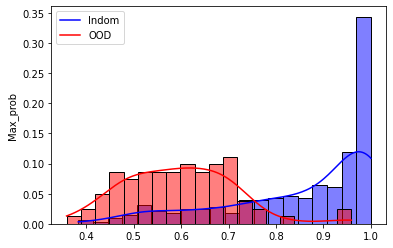

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(max_probs[labels != 3], bins = 20, kde=True, color='blue', stat = 'probability', )
sns.histplot(max_probs[labels == 3], bins = 20, kde=True, color='red', stat = 'probability')
plt.legend(labels=['Indom', 'OOD'])
plt.ylabel("Max_prob")

In [79]:
# Total acc
new_preds = preds
new_preds[max_probs < 0.7] = 3
(new_preds == labels).float().mean()

tensor(0.7912)

In [80]:
# Indom acc
((new_preds == labels) & (labels != 3)).sum() / (labels != 3).sum()

tensor(0.7791)

In [81]:
# OOD acc
((new_preds == labels) & (labels == 3)).sum() / (labels == 3).sum()

tensor(0.8395)

In [82]:
# plt.figure(figsize = (30, 40))

# wrong_indxs = new_preds != labels
# for i, (id, pred, label) in enumerate(zip(ids[wrong_indxs], new_preds[wrong_indxs], labels[wrong_indxs])):
#     plt.subplot(len(ids[preds != labels]) // 2 + 1, 2, i+1)
#     img = dm.test_dataset[id][0]['top_img']
#     plt.imshow(img.permute(1, 2, 0))
#     plt.title('label :' + str(int(label)) + ' pred : ' + str(int(pred)))

/tmp/ipykernel_6743/3075112138.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
/tmp/ipykernel_6743/3075112138.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


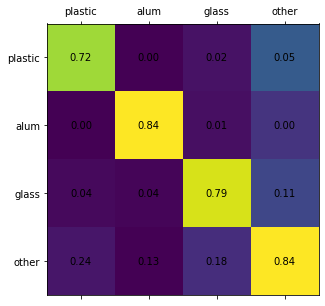

In [83]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np

confmat = ConfusionMatrix(task='multiclass', num_classes=4, normalize='true')
conf_matrix = confmat(new_preds, labels)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

ax.set_xticklabels(['', 'plastic', 'alum', 'glass', 'other'])
ax.set_yticklabels(['', 'plastic', 'alum', 'glass', 'other'])


for (x, y), value in np.ndenumerate(conf_matrix):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

# O